# Second model D+3

Here is a research notebook used for tests.

### Import librairies:

In [1]:
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset:

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

                            IQ  pressure  wind_direction  wind_force  \
date                                                                   
2019-11-03 09:00:00+00:00  0.2  0.936805        0.166667    0.110526   
2019-11-03 12:00:00+00:00  0.2  0.936901        0.944444    0.184211   
2019-11-03 15:00:00+00:00  0.2  0.938435        0.805556    0.205263   
2019-11-03 18:00:00+00:00  0.2  0.940161        0.527778    0.131579   
2019-11-03 21:00:00+00:00  0.2  0.940736        0.527778    0.242105   

                           humidity  temperature  
date                                              
2019-11-03 09:00:00+00:00      0.96     0.248792  
2019-11-03 12:00:00+00:00      0.97     0.263285  
2019-11-03 15:00:00+00:00      0.90     0.275362  
2019-11-03 18:00:00+00:00      0.93     0.219807  
2019-11-03 21:00:00+00:00      0.91     0.234300  


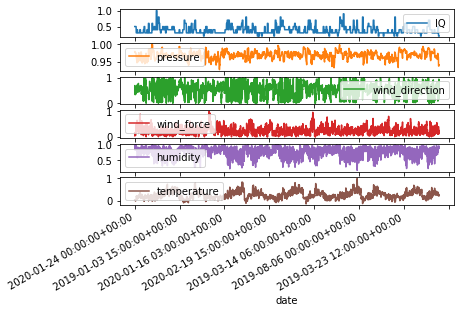

In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(dataset_test,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_direction = max(higher_value(dataset_test,2))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_direction'] = features['wind_direction'].apply(lambda x: x/max_wind_direction)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

print(features.tail())
features.plot(subplots=True)
plt.show()

dataset = features.values

Check that the length of the dataset is a multiple of 8:

In [6]:
if len(dataset)%8!=0:
    raise Exception('ERROR ON THE LENGTH OF THE DATASET, EACH DAY MUST BE 8 MEASURES')

Exception: ERROR ON THE LENGTH OF THE DATASET, EACH DAY MUST BE 8 MEASURES

### Create training data

In [7]:
RANDOM_SHUFFLE_SEED = 0

def createTraining(dataset,nb_measures,nb_features_x,nb_features_y):
    """
    shape the trainning dataset
    """
    chunks = [dataset[x*8:x*8+nb_measures] for x in range(0, int(len(dataset)/8))] #as there is 8 measures each day
    
    # we check that all the chuncks have the same length, as the nb_measures could be longuer than a day
    elementsToRemove = []
    for chunk in chunks: 
        if chunk.shape!=chunks[0].shape:
            elementsToRemove.append(chunk)    
    for e in elementsToRemove:
        chunks.remove(e)        
    chunks = np.array(chunks)  
    
    x_train = chunks[:,:,0:nb_features_x]
    y_train = chunks[:,0,nb_features_y:]
    x_train,y_train = shuffle(x_train,y_train, random_state=RANDOM_SHUFFLE_SEED)
    return(x_train, y_train)

In [8]:
nb_prev_measures_for_predict = 16

x_train,y_train = createTraining(dataset,nb_prev_measures_for_predict,len(features_considered)-3,3)

print("x_train ",x_train.shape)
print("y_train ",y_train.shape)

x_train  (423, 16, 3)
y_train  (423, 3)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


### Load the model or create it:

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU

In [10]:
OPTIMIZER = keras.optimizers.RMSprop(learning_rate=0.005)
LOSS = 'mae'

if LOAD_MODEL: 
    model = keras.models.load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])

    model = Sequential()
    model.add(LSTM(512, input_shape=input_shape,name='LSTM_layer'))
    model.add(Dense(3,name="Dense_layer"))
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_layer (LSTM)            (None, 512)               1056768   
_________________________________________________________________
Dense_layer (Dense)          (None, 3)                 1539      
Total params: 1,058,307
Trainable params: 1,058,307
Non-trainable params: 0
_________________________________________________________________


### Train

In [ ]:
EPOCHS = 40
kfoldsize = 5

tensor_board = tf.keras.callbacks.TensorBoard('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    model.fit(x=x, y=y, validation_data=(x_val,y_val),epochs=EPOCHS)

Train on 338 samples, validate on 85 samples
Epoch 1/40
338/338 [==============================] - 2s 5ms/step - loss: 2.0538 - val_loss: 0.2931
Epoch 2/40
338/338 [==============================] - 1s 4ms/step - loss: 0.3264 - val_loss: 0.3386
Epoch 3/40
338/338 [==============================] - 1s 4ms/step - loss: 0.2441 - val_loss: 0.1658
Epoch 4/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1993 - val_loss: 0.1905
Epoch 5/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1884 - val_loss: 0.1282
Epoch 6/40
338/338 [==============================] - 2s 6ms/step - loss: 0.1751 - val_loss: 0.1817
Epoch 7/40
338/338 [==============================] - 1s 4ms/step - loss: 0.1613 - val_loss: 0.1347
Epoch 8/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1681 - val_loss: 0.1461
Epoch 9/40
338/338 [==============================] - 2s 4ms/step - loss: 0.1540 - val_loss: 0.1644
Epoch 10/40
338/338 [==============================] - 

338/338 [==============================] - 2s 5ms/step - loss: 0.1138 - val_loss: 0.1175
Epoch 2/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1126 - val_loss: 0.1133
Epoch 3/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1137 - val_loss: 0.1171
Epoch 4/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1136 - val_loss: 0.1151
Epoch 5/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1125 - val_loss: 0.1161
Epoch 6/40
338/338 [==============================] - 1s 4ms/step - loss: 0.1100 - val_loss: 0.1108
Epoch 7/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1145 - val_loss: 0.1146
Epoch 8/40
338/338 [==============================] - 2s 5ms/step - loss: 0.1141 - val_loss: 0.1124
Epoch 9/40
338/338 [==============================] - 2s 6ms/step - loss: 0.1141 - val_loss: 0.1148
Epoch 10/40
338/338 [==============================] - 1s 4ms/step - loss: 0.1138 - val_loss: 0.1214
Epoch 11/4

### See the training in tensorboard

In [ ]:
#%tensorboard --logdir=./logs

### See the results

In [ ]:
def calc_accuracy_3days(y_pred,y_true):
    """
    calculate the accurracy of the prediction according to the true value for each day [D+1, D+2, D+3]
    """
    accuracy = [0,0,0]
    for pred,true in zip (y_pred,y_true):
        for plusDay in range(3):
            if true[plusDay] == round(pred[plusDay]):
                accuracy[plusDay]+=1
    return(np.array(accuracy)/len(y_true)*100)
    
def mean_error_3days(y_pred,y_true):
    """
    calculate the mean error between the prediction and the true value for each day [D+1, D+2, D+3]
    """
    error = [0,0,0]
    for pred,true in zip (y_pred,y_true):
        for plusDay in range(3):
            error[plusDay] += abs(true[plusDay] - pred[plusDay])
    return(np.array(error)/len(y_true))

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [ ]:
y_pred = model.predict(x_train)
accuracy = calc_accuracy_3days(y_pred,y_train)
meanError = mean_error_3days(y_pred,y_train)

Show the results in graphs:

In [ ]:
print('Prediction of the air index quality (on training data)')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train[:,plusDay], label='Real')
    plt.plot(y_pred[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()

    print("Accuracy with training data:",round(accuracy[plusDay],2),"%")
    print("Mean error with training data:",round(meanError[plusDay],2))
